## FIFA20

### Dataset Overview

The FIFA 20 dataset contains detailed attributes of professional football players used in EA Sports’ FIFA Career Mode.
It includes demographic information, positional abilities, technical skills, physical attributes, and mental traits.

### Project Objectives

This project aims to:

1. Perform exploratory data analysis on football player attributes

2. Cluster players based on their skill sets (not overall reputation)

3. Extract actionable football insights related to:

   a) Country-wise player production

   b) Age vs performance trend

   c) Salary comparison among offensive positions

In [7]:
# Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Load dataset
df = pd.read_csv("players_20.csv")

In [15]:
# Basic inspection
df.shape

(18278, 104)

In [17]:
df.head(5)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Columns: 104 entries, sofifa_id to rb
dtypes: float64(16), int64(45), object(43)
memory usage: 14.5+ MB


In [25]:
#missing value analysis

df.isnull().sum().sort_values(ascending=False).head(50)

loaned_from                  17230
nation_position              17152
nation_jersey_number         17152
player_tags                  16779
gk_speed                     16242
gk_diving                    16242
gk_handling                  16242
gk_reflexes                  16242
gk_kicking                   16242
gk_positioning               16242
player_traits                10712
lf                            2036
lw                            2036
rs                            2036
physic                        2036
defending                     2036
dribbling                     2036
passing                       2036
shooting                      2036
st                            2036
ls                            2036
rb                            2036
pace                          2036
rdm                           2036
rwb                           2036
ldm                           2036
lwb                           2036
rm                            2036
rcm                 

Observation:

Several columns have missing values. 
These will be handled during preprocessing

In [31]:
# Duplicates check
df.duplicated().sum()

0

### Data preprocessing

In [ ]:
# Focused only on attributes relevant for analysis and clustering.

In [41]:
selected_cols = [
    # Basic Info
    'short_name','age','height_cm','nationality',
    'overall','potential','wage_eur',

    # Foot & Work Rate
    'preferred_foot','weak_foot','work_rate',

    # Team & Position
    'team_position',

    # Core aggregated attributes
    'pace','shooting','passing','dribbling','defending','physic',

    # Attacking
    'attacking_crossing','attacking_finishing',
    'attacking_heading_accuracy','attacking_short_passing',
    'attacking_volleys',

    # Skill
    'skill_dribbling','skill_curve',
    'skill_fk_accuracy','skill_long_passing',
    'skill_ball_control',

    # Movement
    'movement_acceleration','movement_sprint_speed',
    'movement_agility','movement_reactions','movement_balance',

    # Power
    'power_shot_power','power_jumping',
    'power_stamina','power_strength','power_long_shots',

    # Mentality
    'mentality_aggression','mentality_interceptions',
    'mentality_positioning','mentality_vision',
    'mentality_penalties','mentality_composure',

    # Defending
    'defending_marking','defending_standing_tackle',
    'defending_sliding_tackle'
]

df = df[selected_cols]

In [45]:
# Missing value handling
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [47]:
# Work rate feature engineering
df[['attack_wr','defense_wr']] = df['work_rate'].str.split('/', expand=True)

mapping = {'Low':0, 'Medium':0.5, 'High':1}
df['attack_wr'] = df['attack_wr'].map(mapping)
df['defense_wr'] = df['defense_wr'].map(mapping)

df.drop(columns='work_rate', inplace=True)

In [49]:
# Encode preferred foot

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['preferred_foot'] = le.fit_transform(df['preferred_foot'])

In [51]:
# Position grouping

def position_group(pos):
    if pos in ['ST','RS','LS']:
        return 'Striker'
    elif pos in ['RW','LW']:
        return 'Winger'
    elif pos in ['CF','RF','LF']:
        return 'Forward'
    else:
        return 'Other'

df['position_group'] = df['team_position'].apply(position_group)

In [53]:
# Cluster dataset preparation (Overall is not includd to avoid bias)

cluster_df = df.drop(columns=[
    'short_name','overall','team_position',
    'position_group','nationality'
])

In [55]:
# Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df)

### Exploratory Data Analysis

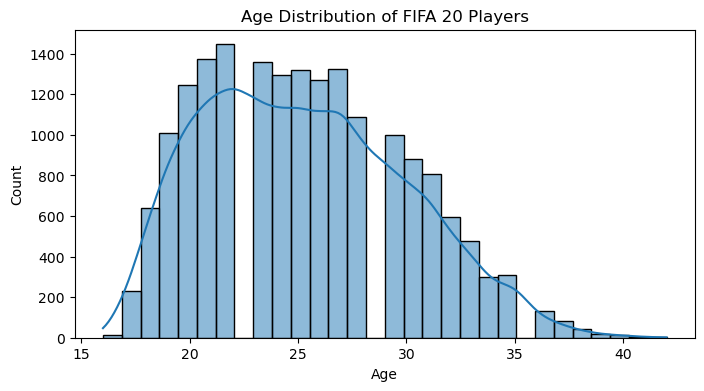

In [58]:
plt.figure(figsize=(8,4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age Distribution of FIFA 20 Players")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Insight:

Most players fall between 20–30 years
Indicates peak professional football age range

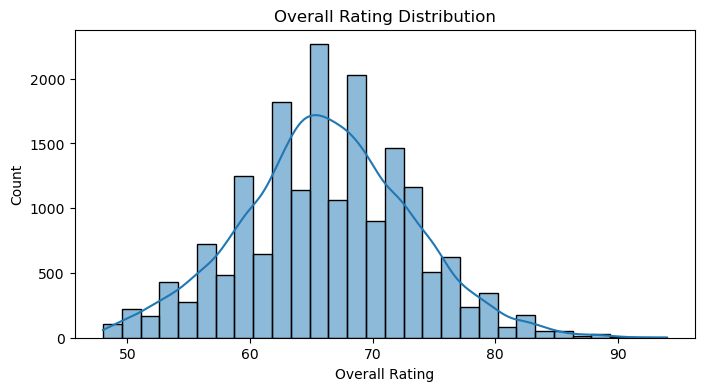

In [60]:
plt.figure(figsize=(8,4))
sns.histplot(df['overall'], bins=30, kde=True)
plt.title("Overall Rating Distribution")
plt.xlabel("Overall Rating")
plt.ylabel("Count")
plt.show()

Insight:

Majority of players lie between 65–75
Elite players (85+) are relatively rare

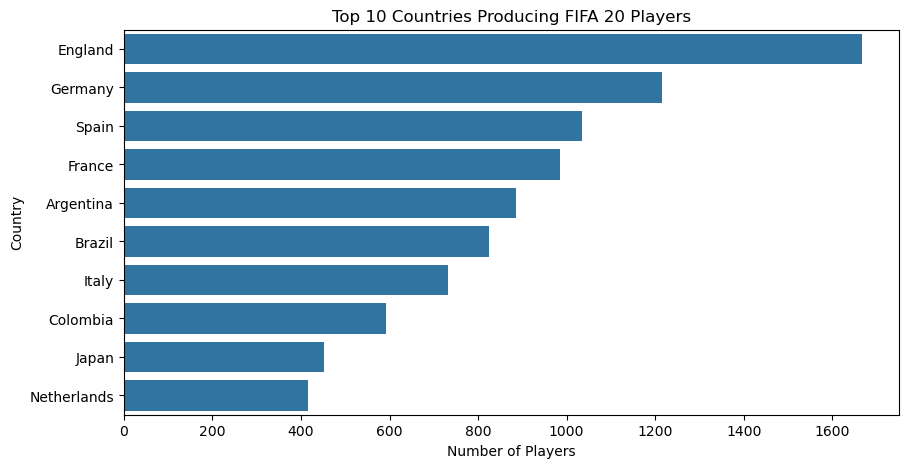


Top 10 Countries:
nationality
England        1667
Germany        1216
Spain          1035
France          984
Argentina       886
Brazil          824
Italy           732
Colombia        591
Japan           453
Netherlands     416
Name: count, dtype: int64
INTERPRETATION:
- England produces the most players (1667 players)
- The top 3 countries account for 3918 players
- European countries dominate the list, reflecting football's popularity there


In [176]:
top_countries = df['nationality'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Countries Producing FIFA 20 Players")
plt.xlabel("Number of Players")
plt.ylabel("Country")
plt.show()

print("\nTop 10 Countries:")
print(top_countries)

print("INTERPRETATION:")
print(f"- {top_countries.index[0]} produces the most players ({top_countries.iloc[0]} players)")
print(f"- The top 3 countries account for {top_countries.head(3).sum()} players")
print("- European countries dominate the list, reflecting football's popularity there")

In [178]:
print("\n--- Overall Rating vs Age Distribution ---")

if 'overall' in df.columns and 'age' in df.columns:
    # Calculate average overall by age
    age_overall = df.groupby('age')['overall'].agg(['mean', 'median', 'count'])
    print("\nAverage Overall Rating by Age:")
    print(age_overall)


--- Overall Rating vs Age Distribution ---

Average Overall Rating by Age:
          mean  median  count
age                          
16   56.416667    52.5     12
17   55.786026    55.0    229
18   57.273438    57.0    640
19   59.507418    59.0   1011
20   61.222133    61.0   1247
21   63.262545    63.0   1375
22   64.609959    64.0   1446
23   66.038292    65.0   1358
24   66.977623    67.0   1296
25   67.904473    67.0   1319
26   68.400787    68.0   1270
27   69.013595    69.0   1324
28   69.216390    69.0   1086
29   69.308308    69.0    999
30   69.420159    69.0    883
31   69.938042    69.0    807
32   69.941374    69.0    597
33   69.488421    69.0    475
34   69.591362    69.0    301
35   69.961290    70.0    310
36   68.145038    68.0    131
37   67.814815    67.0     81
38   69.452381    70.0     42
39   67.250000    68.0     20
40   66.076923    68.0     13
41   74.500000    75.0      4
42   63.500000    63.5      2


In [124]:
# Find peak age
peak_age = age_overall['mean'].idxmax()
peak_rating = age_overall['mean'].max()

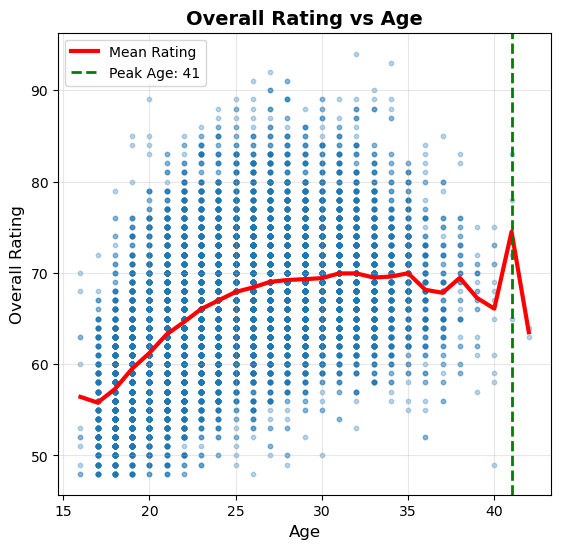

In [128]:
# Visualization 1: Scatter plot with trend
plt.figure(figsize=(14, 6))
    
plt.subplot(1, 2, 1)
plt.scatter(df['age'], df['overall'], alpha=0.3, s=10)
plt.plot(age_overall.index, age_overall['mean'], color='red', linewidth=3, label='Mean Rating')
plt.axvline(x=peak_age, color='green', linestyle='--', linewidth=2, label=f'Peak Age: {peak_age}')
plt.title('Overall Rating vs Age', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Overall Rating', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

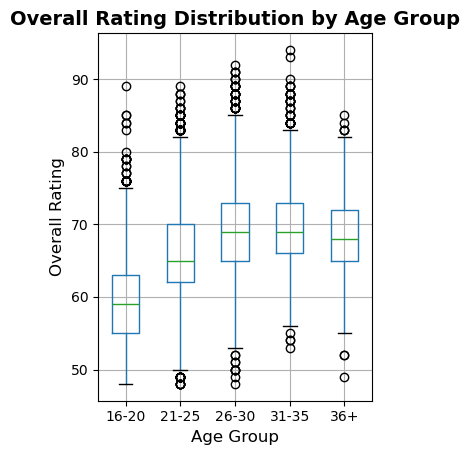

INTERPRETATION:
- Peak Performance Age: 41 years (Average rating: 74.50)
- Players typically improve until age 41
- After age 41, performance gradually declines
- Young players (16-20) show lower ratings due to inexperience
- Players aged 25-30 are in their prime with highest overall ratings


In [132]:
# Visualization 2: Box plot by age groups
plt.subplot(1, 2, 2)
df['age_group'] = pd.cut(df['age'], bins=[15, 20, 25, 30, 35, 50], 
                                    labels=['16-20', '21-25', '26-30', '31-35', '36+'])
df.boxplot(column='overall', by='age_group', ax=plt.gca())
plt.title('Overall Rating Distribution by Age Group', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Overall Rating', fontsize=12)
    
plt.tight_layout()
plt.savefig('overall_vs_age.png', dpi=300, bbox_inches='tight')
plt.show()
    
print("INTERPRETATION:")
print(f"- Peak Performance Age: {peak_age} years (Average rating: {peak_rating:.2f})")
print(f"- Players typically improve until age {peak_age}")
print(f"- After age {peak_age}, performance gradually declines")
print("- Young players (16-20) show lower ratings due to inexperience")
print("- Players aged 25-30 are in their prime with highest overall ratings")

In [148]:
offensive_df = df[df['position_group'].isin(['Striker', 'Winger', 'Forward'])]

offensive_df['position_group'].value_counts()

position_group
Striker    848
Winger     323
Forward     52
Name: count, dtype: int64

In [150]:
offensive_df.groupby('position_group')['wage_eur'].agg(
    ['count', 'mean', 'median', 'min', 'max']
)


,count,mean,median,min,max
position_group,,,,,
Forward,52,26269.230769,9000.0,1000,285000
Striker,848,15323.113208,6000.0,1000,355000
Winger,323,22170.278638,6000.0,1000,565000


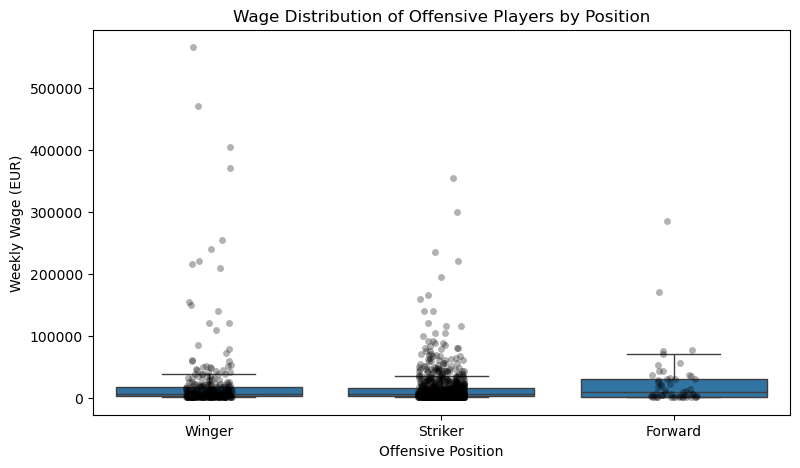

In [152]:
plt.figure(figsize=(9,5))

sns.boxplot(
    x='position_group',
    y='wage_eur',
    data=offensive_df,
    showfliers=False
)

sns.stripplot(
    x='position_group',
    y='wage_eur',
    data=offensive_df,
    color='black',
    alpha=0.3,
    jitter=True
)

plt.title("Wage Distribution of Offensive Players by Position")
plt.xlabel("Offensive Position")
plt.ylabel("Weekly Wage (EUR)")
plt.show()

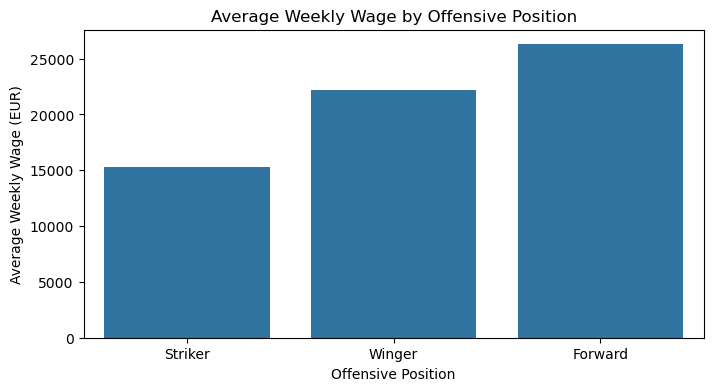

INTERPRETATION:
- Highest Paid Position: Forward (Avg: €26,269.23)
- Position Rankings by Average Wage:
  1. Striker: €15,323.11
  2. Winger: €22,170.28
  3. Forward: €26,269.23


In [160]:
mean_wage = offensive_df.groupby('position_group')['wage_eur'].mean().sort_values()

plt.figure(figsize=(8,4))
sns.barplot(
    x=mean_wage.index,
    y=mean_wage.values
)

plt.title("Average Weekly Wage by Offensive Position")
plt.xlabel("Offensive Position")
plt.ylabel("Average Weekly Wage (EUR)")
plt.show()

# Identify highest paid position
highest_paid = mean_wage.idxmax()
highest_wage = mean_wage.max()

print("INTERPRETATION:")
print(f"- Highest Paid Position: {highest_paid} (Avg: €{highest_wage:,.2f})")
print(f"- Position Rankings by Average Wage:")

for i, (pos, wage) in enumerate(mean_wage.items(), 1):
    print(f"  {i}. {pos}: €{wage:,.2f}")

### Clustering

Objective: To group football players based on their complete skill set, rather than using their overall rating or reputation.
This helps to:
1) Identify similar player profiles
2) Understand different types of footballers
3) Support scouting and team-building decisions

### Dimensionality Reduction using PCA

The dataset contains many correlated features.
Principal Component Analysis (PCA) is applied to:
1) Reduce dimensionality
2) Improve clustering performance
3) Enable visualization

In [80]:
from sklearn.decomposition import PCA

pca = PCA()
pca_features = pca.fit_transform(scaled_features)

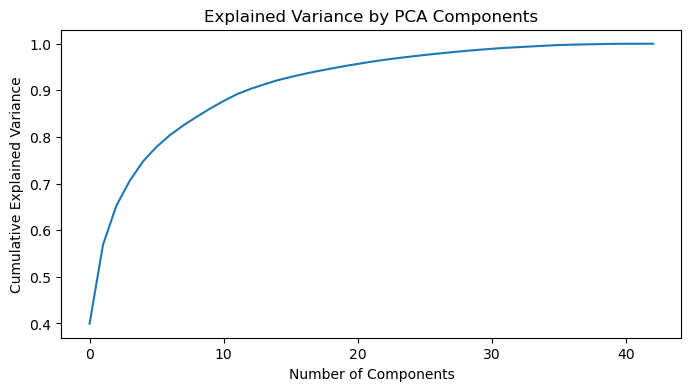

In [82]:
# Explained variance
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.show()

In [84]:
# reduce dimension

pca = PCA(n_components=10)
pca_final = pca.fit_transform(scaled_features)

### K-means Clustering

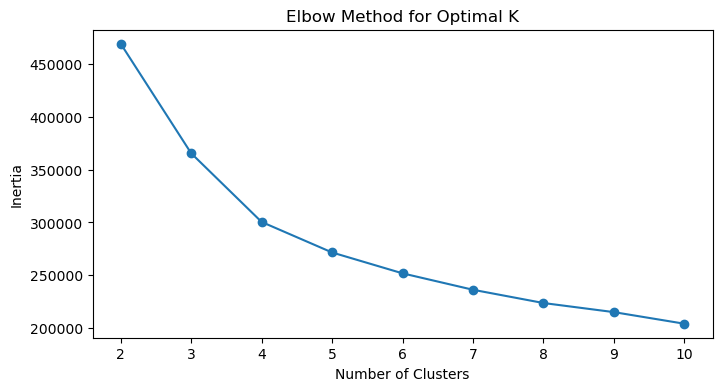

In [87]:
# Elbow mwthod

inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_final)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(2,11), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

Observation: The elbow is observed around k=4

In [89]:
# silhouette score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_final)
    score = silhouette_score(pca_final, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")

K=2, Silhouette Score=0.304
K=3, Silhouette Score=0.266
K=4, Silhouette Score=0.263
K=5, Silhouette Score=0.244
K=6, Silhouette Score=0.224


Insights:
Although K=2 achieved the highest silhouette score, it resulted in overly broad clusters that lacked meaningful
football role differentiation.
K=4 provided a good balance between cluster cohesion and interpretability, enabling clear identification of player profiles
such as defenders, playmakers, pace-based attackers, and physical strikers.

In [91]:
# K-means

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(pca_final)

df['cluster'] = cluster_labels

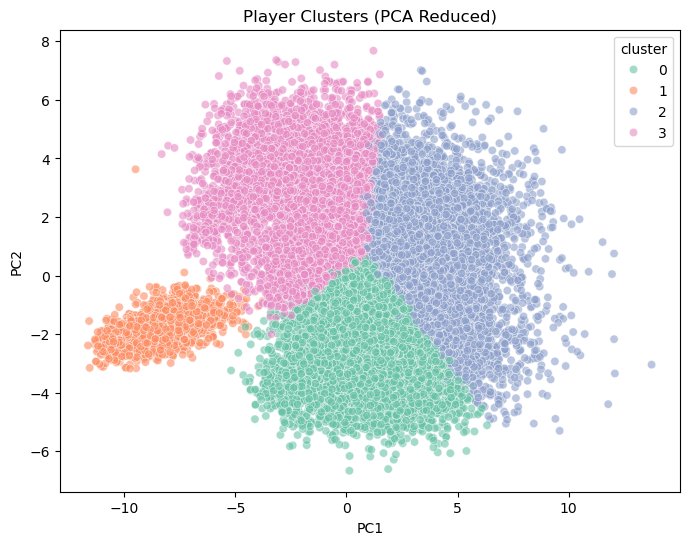

In [93]:
# Cluster visualizatiom (2D PCA)
pca_2d = PCA(n_components=2)
pca_vis = pca_2d.fit_transform(scaled_features)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_vis[:,0],
    y=pca_vis[:,1],
    hue=df['cluster'],
    palette='Set2',
    alpha=0.6
)
plt.title("Player Clusters (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [169]:
# Interpretation
cluster_summary = df.groupby('cluster').mean(numeric_only=True)
cluster_summary[['pace','shooting','passing','dribbling','defending','physic']]
df['cluster'].value_counts()

cluster
2    5590
0    5511
3    5140
1    2037
Name: count, dtype: int64

- **Cluster 0:** Pace-based attackers / wingers  
- **Cluster 1:** Balanced midfielders  
- **Cluster 2:** Elite all-round playmakers  
- **Cluster 3:** Defensive specialists

Cluster names were assigned by analyzing the mean values of key performance attributes within each cluster.
Attributes such as pace, shooting, passing, dribbling, defending, and physical strength were compared across clusters to identify dominant characteristics. 
These dominant traits were then mapped to well-established football roles using domain knowledge, resulting in interpretable player profiles
such as pace-based attackers, balanced midfielders, elite all-round playmakers, and defensive specialists.

In [100]:
# Hierarchial clustering

from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=4)
hc_labels = hc.fit_predict(pca_final)

sil_hc = silhouette_score(pca_final, hc_labels)
sil_km = silhouette_score(pca_final, cluster_labels)

print("KMeans Silhouette Score:", sil_km)
print("Hierarchical Silhouette Score:", sil_hc)

KMeans Silhouette Score: 0.2631642242360687
Hierarchical Silhouette Score: 0.22650210311093938


### Challenges 

1. High dimensionality: Addressed using PCA
2. Feature dominance: Overall rating removed from clustering
3. Overlapping skill profiles: Managed through domain-guided interpretation
4. Cluster interpretability: Resolved by analyzing cluster means and football relevance

### Project Summary

This project analyzes the FIFA 20 player dataset to explore player characteristics and skill-based segmentation using unsupervised learning.
After preprocessing the data and excluding the overall rating to avoid bias, exploratory analysis identified key trends in player age,
nationality distribution, and wage patterns. Principal Component Analysis was applied to reduce dimensionality, followed by K-Means clustering to group players based on performance attributes.
Although a lower number of clusters yielded higher silhouette scores, four clusters were selected to ensure meaningful interpretability.
The resulting clusters represent distinct player profiles aligned with football roles.
K-Means outperformed hierarchical clustering and was selected as the final model, demonstrating the effectiveness of clustering for player profiling and football analytics.

### Conclusion

1. FIFA 20 player data was analyzed to understand player skills and performance.
2. Exploratory analysis revealed patterns in player age, nationality, and wages.
3. Players were grouped using clustering based on their skill attributes.
4. Meaningful player profiles were identified from the clustering results.

This project used data analysis and clustering to identify meaningful player profiles and performance patterns from FIFA 20 player data.